In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
from sklearn.utils import shuffle

In [2]:
path =  ['/home/ayon/Database/IsolatedTrain/', '/home/ayon/Database/IsolatedTest/']

In [4]:
def load_data(path):
    train_path ,test_path = path 
    sub_paths = os.listdir(train_path)

    img_data = []
    label_data = []
    
    c = 0
    
    img_paths = [os.path.join(root, file) for root, dirs, files in os.walk(train_path) for file in files]
        
    for img_path in img_paths:
        img = cv2.imread(img_path, 0)
        if img is None : continue
        img = cv2.resize(img, (32, 32), cv2.INTER_AREA)
        img_data.append(img)
        label = int(load_label(img_path))
        label_data.append(label)
        c = c + 1
#             print(img_path)
        
    img_data, label_data = shuffle(np.expand_dims(np.array(img_data),-1), label_data) #converting  to a numpy array
    label_data = to_one_hot(label_data, 171)
    return img_data, label_data

In [5]:
def to_one_hot(label_data, num_class):
    num_sample = np.shape(label_data)[0]
    temp = np.zeros([num_sample, num_class])
    temp[np.arange(num_sample),label_data] = 1
    return temp

In [6]:
def Network(Input): #input : [Batch_size, 32, 32, 1]
    with tf.name_scope("Network"):
        conv1 = tf.layers.conv2d(Input, filters = 64, kernel_size = 3, strides = 1, activation = tf.nn.relu, name = 'conv1')
        conv2 = tf.layers.conv2d(conv1, filters = 64, kernel_size = 3, strides = 1, activation = tf.nn.relu, name = 'conv2')
        pool1 = tf.layers.max_pooling2d(conv2, pool_size = 2, strides = 2, name = 'pool1')

        conv3 = tf.layers.conv2d(pool1, filters = 256, kernel_size = 3, strides = 1, activation = tf.nn.relu, name = 'conv3')
        conv4 = tf.layers.conv2d(conv3, filters = 256, kernel_size = 3, strides = 1, activation = tf.nn.relu, name = 'conv4')
        pool2 = tf.layers.max_pooling2d(conv4, pool_size = 2, strides = 2, name = 'pool2')

        conv5 = tf.layers.conv2d(pool2, filters = 512, kernel_size = 3, strides = 1, activation = tf.nn.relu, name = 'conv5')

        flat = tf.contrib.layers.flatten(conv5)
        fc1 = tf.layers.dense(flat, units = 1024, activation = tf.nn.relu, name = 'fc1')
        fc2 = tf.layers.dense(fc1, units = 171, activation = None, name = 'fc2')
    
    return fc2
    
    

In [7]:
def loss_function(logit, Label):
    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = logit, labels = Label))
    return loss

In [8]:
def Accuracy_Evaluate(prediction, Label):
    # Evaluate model
    correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Label, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    return correct_pred, accuracy

In [9]:
def main(train_data, train_label, no_of_epochs = 200, batchsize = 32):
    
    
    Input = tf.placeholder(dtype = tf.float32, shape = [None, 32, 32, 1])
    Label = tf.placeholder(dtype = tf.float32, shape = [None, 171])
    
    logit = Network(Input)
    
    prediction = tf.nn.softmax(logit)
    
    loss = loss_function(logit, Label)
    
    correct_pred, accuracy = Accuracy_Evaluate(prediction, Label)
    
    
    optimiz = tf.train.GradientDescentOptimizer(learning_rate = 0.0001).minimize(loss)

    init = tf.global_variables_initializer()
    sess.run(init)
 
    
    tf.summary.scalar('Loss_Value',loss)
    tf.summary.scalar('Accuracy',accuracy)
    
    print('Stteing up summary op...')
    summary_op = tf.summary.merge_all()
    
    print('Setting Up Saver...')
    summary_writer = tf.summary.FileWriter('./log_dir/', sess.graph)
    
    itr = 0
    for epoch in range(no_of_epochs):
        
        index = np.random.permutation(np.shape(train_data)[0])
        train_data = train_data[index, :, :, :]
        train_label = train_label[index, :]
        
        for idx in range(train_data.shape[0]//batchsize): 
            
            batchx = train_data[idx*batchsize : (idx + 1)*batchsize , :, :, :]
            batchy = train_label[idx*batchsize : (idx + 1)*batchsize, :]
            
            feed_dict = {Input : batchx , Label : batchy}
            
            _, train_loss, train_accuracy, summary_str = sess.run([optimiz, loss, accuracy, summary_op] , feed_dict )
            summary_writer.add_summary(summary_str, itr)
            itr = itr + 1
            
            if idx%10 == 0:
                
                print ('epoch : '+str(epoch)+' step : '+str(idx) + ' train_loss : '+str(train_loss) +
                        ' train_accuracy : '+str(train_accuracy) 
            
                      )

In [10]:
from tensorflow.python.framework import ops
ops.reset_default_graph()
global sess

config = tf.ConfigProto()
sess = tf.Session(config = config)
graph = tf.get_default_graph()

In [11]:
train_data, train_label = load_data(path)
print(len(train_data))

34439


In [12]:
train_data.shape

(34439, 32, 32, 1)

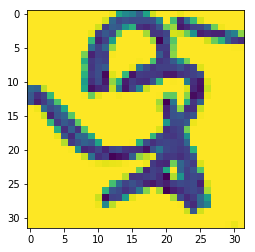

76


In [13]:
plt.imshow(train_data[110,:,:,0])
plt.show()
print(np.argmax(train_label[110]))

In [ ]:
main(train_data, train_label)

In [ ]:
# Resource
# https://stackoverflow.com/questions/29831489/numpy-1-hot-array